# Deep in the Sky: Analysis on on-time performance data of airlines in US

The second fact I am looking into is the effect from airports. To accomplish this, I collect airport info data from BTS and use Basemap to vitualize geometrical data. First let's see how the delay probability change among airports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap

airdf=pd.read_csv('data/airport.csv')
airdf=airdf.drop_duplicates('AIRPORT').reset_index()
airdf=airdf.set_index('AIRPORT')
airdf=airdf[['LATITUDE','LONGITUDE']]

newcols=['dep_count','arr_count','cancel_count','delay_dep_tot','delay_count','delay15',
         'carrier_dcount','weather_dcount','security_dcount','NAS_dcount','late_dcount']
for col in newcols:
    airdf[col]=0

for m in range(1,13):
    file='data/On_Time_On_Time_Performance_2017_'+str(m)+'.csv'
    df=pd.read_csv(file,usecols=list(range(61)),low_memory=False)
    dep=df.groupby('Origin')['Year'].count()
    airdf.loc[dep.index,'dep_count']+=dep
    arr=df.groupby('Dest')['Year'].count()
    airdf.loc[arr.index,'arr_count']+=arr
    cancel=df.groupby('Origin')['Cancelled'].sum()
    airdf.loc[cancel.index,'cancel_count']+=cancel
    delay=df.groupby('Origin')['DepDel15'].sum()
    airdf.loc[cancel.index,'delay15']+=delay
    delay=df.groupby('Origin')['DepDelayMinutes'].sum()
    airdf.loc[delay.index,'delay_dep_tot']+=delay
    delay=df[df.DepDelayMinutes>0].groupby('Origin')['Year'].count()
    airdf.loc[delay.index,'delay_count']+=delay

    delay=df[(df.CarrierDelay>0)|(df.CancellationCode=='A')].groupby('Origin')['Year'].count()
    airdf.loc[delay.index,'carrier_dcount']+=delay
    delay=df[(df.WeatherDelay>0)|(df.CancellationCode=='B')].groupby('Origin')['Year'].count()
    airdf.loc[delay.index,'weather_dcount']+=delay
    delay=df[(df.SecurityDelay>0)|(df.CancellationCode=='D')].groupby('Origin')['Year'].count()
    airdf.loc[delay.index,'security_dcount']+=delay
    delay=df[(df.NASDelay>0)|(df.CancellationCode=='C')].groupby('Origin')['Year'].count()
    airdf.loc[delay.index,'NAS_dcount']+=delay
    delay=df[df.LateAircraftDelay>0].groupby('Origin')['Year'].count()
    airdf.loc[delay.index,'late_dcount']+=delay

pdata=airdf[airdf.dep_count>100]
pdata.avg_delay=pdata.delay_dep_tot/(pdata.dep_count-pdata.cancel_count)
pdata.cancel_rate=pdata.cancel_count/pdata.dep_count
pdata.delay_rate=pdata.delay_count/pdata.dep_count

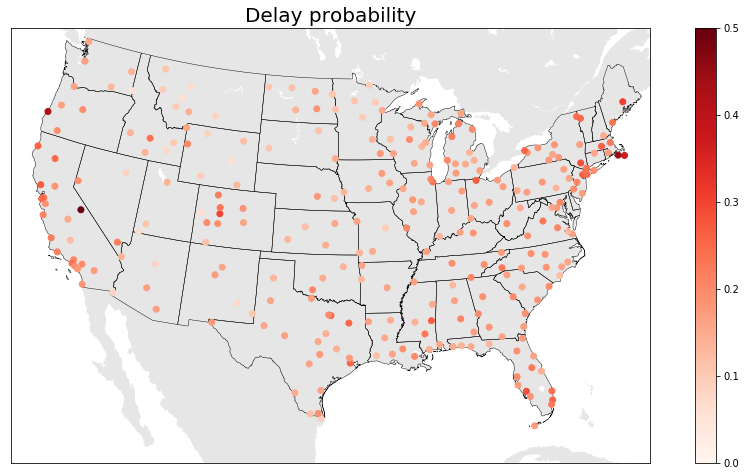

In [2]:
ax=plt.figure(figsize=(16,8)).add_subplot(111)
ax.set_title('Delay probability',fontsize=20)
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='l',ax=ax)
shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=.45,color='k')
m.fillcontinents(color=(.9,.9,.9))
xpt,ypt=m(list(pdata['LONGITUDE']),list(pdata['LATITUDE']))

pl=m.scatter(xpt,ypt,c=(pdata.delay15+pdata.cancel_count)/pdata.dep_count,cmap='Reds',vmin=0,vmax=.5,zorder=10,ax=ax)
plt.colorbar(pl)
plt.show()

Here we can see the difference of delay probabilities throughout the US. Airports at NorthWest has low delay probabilities, while flights in some big coastal cities like Boston has more than 40% delayed flights in 2017.

Maybe the high delay probabilities of flights in coastal cities is due to the weather. Let's plot out the probability map of weather delayed flights and carrier delayed flights.

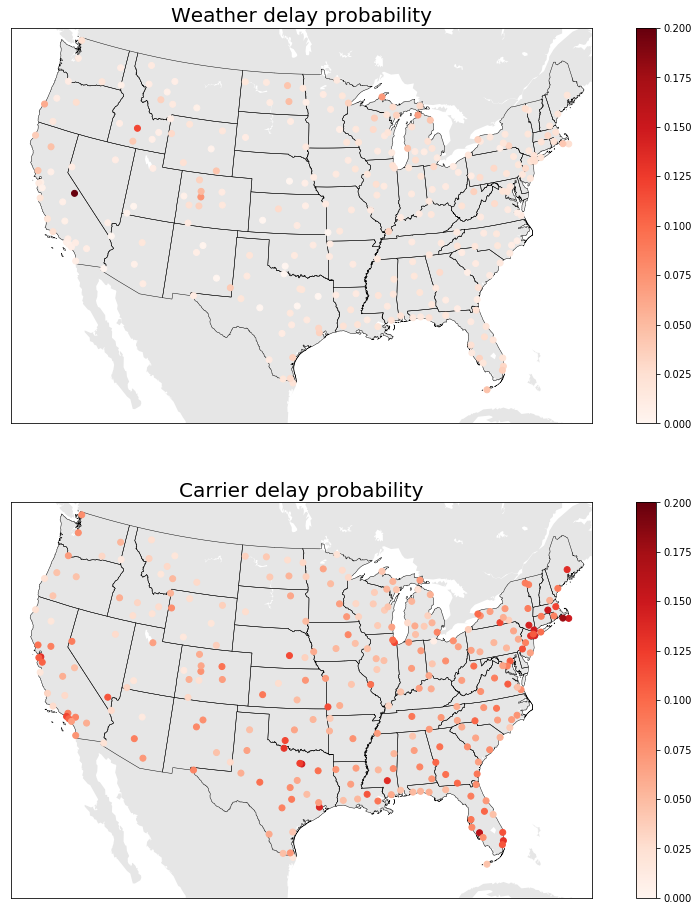

In [3]:
fig=plt.figure(figsize=(16,16))
ax1=fig.add_subplot(211)
ax1.set_title('Weather delay probability',fontsize=20)
m1 = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='l',ax=ax1)
shp_info = m1.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=.45,color='k')
m1.fillcontinents(color=(.9,.9,.9))
xpt,ypt=m(list(pdata['LONGITUDE']),list(pdata['LATITUDE']))

pl1=m.scatter(xpt,ypt,c=pdata.weather_dcount/pdata.dep_count,cmap='Reds',vmin=0,vmax=.2,zorder=10,ax=ax1)
plt.colorbar(pl1)
ax2=fig.add_subplot(212)
ax2.set_title('Carrier delay probability',fontsize=20)
m2 = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='l',ax=ax2)
shp_info = m2.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=.45,color='k')
m2.fillcontinents(color=(.9,.9,.9))
xpt,ypt=m(list(pdata['LONGITUDE']),list(pdata['LATITUDE']))

pl2=m.scatter(xpt,ypt,c=pdata.carrier_dcount/pdata.dep_count,cmap='Reds',vmin=0,vmax=.2,zorder=10,ax=ax2)
plt.colorbar(pl2)
plt.show()

It is interesting to see that most delayed cause is carrier but not the weather. Will continue to investigate if carrier-caused-delay is relavant to carriers themselves.